# Import necessary dependencies

In [1]:
import time

# Data Wrangling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# Data Saving
import pickle

# Feature Extraction and Feature Engineering
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, auc, classification_report, confusion_matrix

# Model Interpretation
import eli5
from eli5.sklearn import PermutationImportance


/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# Load Data for Machine Learning

In [2]:
# take a peek at the data
df = pd.read_pickle('small_df.pickle')
print(df.head())

# shuffle the data and reset index
data = df.sample(len(df))
data = df.reset_index(drop=True)

# build train, validation and test datasets 
data_valid_test = data.sample(frac=0.3)
data_test = data_valid_test.sample(frac=0.5) 
data_valid = data_valid_test.drop(data_test.index) 
data_train = data.drop(data_valid_test.index)

                                          TEXT_CLEAN  Label
0  admission date                discharge date  ...      0
1  admission date                discharge date  ...      0
2  admission date                discharge date  ...      0
3  admission date                discharge date  ...      0
4  admission date                discharge date  ...      0


# Supervised Machine Learning Models
**STEPS:**
* Prepare Stop Words for the medical corpus
* Extract TFIDF vectors for the discharge summaries
* Train tree based classifiers

## Prepare "stop words" for medical corpus
**MEDICAL_STOP_WORDS** = **ENGLISH_STOPWORDS** + 
                         **MOST FREQUENT WORDS IN THE CORPUS** + 
                         **LEAST FREQUENT WORDS IN THE CORPUS**

In [3]:
# English stopwords from Reuters
stopwords = ['a', 'about', 'above', 'across', 'after', 'afterwards']
stopwords += ['again', 'against', 'all', 'almost', 'alone', 'along']
stopwords += ['already', 'also', 'although', 'always', 'am', 'among']
stopwords += ['amongst', 'amoungst', 'amount', 'an', 'and', 'another']
stopwords += ['any', 'anyhow', 'anyone', 'anything', 'anyway', 'anywhere']
stopwords += ['are', 'around', 'as', 'at', 'back', 'be', 'became']
stopwords += ['because', 'become', 'becomes', 'becoming', 'been']
stopwords += ['before', 'beforehand', 'behind', 'being', 'below']
stopwords += ['beside', 'besides', 'between', 'beyond', 'bill', 'both']
stopwords += ['bottom', 'but', 'by', 'call', 'can', 'cannot', 'cant']
stopwords += ['co', 'computer', 'con', 'could', 'couldnt', 'cry', 'de']
stopwords += ['describe', 'detail', 'did', 'do', 'done', 'down', 'due']
stopwords += ['during', 'each', 'eg', 'eight', 'either', 'eleven', 'else']
stopwords += ['elsewhere', 'empty', 'enough', 'etc', 'even', 'ever']
stopwords += ['every', 'everyone', 'everything', 'everywhere', 'except']
stopwords += ['few', 'fifteen', 'fifty', 'fill', 'find', 'fire', 'first']
stopwords += ['five', 'for', 'former', 'formerly', 'forty', 'found']
stopwords += ['four', 'from', 'front', 'full', 'further', 'get', 'give']
stopwords += ['go', 'had', 'has', 'hasnt', 'have', 'he', 'hence', 'her']
stopwords += ['here', 'hereafter', 'hereby', 'herein', 'hereupon', 'hers']
stopwords += ['herself', 'him', 'himself', 'his', 'how', 'however']
stopwords += ['hundred', 'i', 'ie', 'if', 'in', 'inc', 'indeed']
stopwords += ['interest', 'into', 'is', 'it', 'its', 'itself', 'keep']
stopwords += ['last', 'latter', 'latterly', 'least', 'less', 'ltd', 'made']
stopwords += ['many', 'may', 'me', 'meanwhile', 'might', 'mill', 'mine']
stopwords += ['more', 'moreover', 'most', 'mostly', 'move', 'much']
stopwords += ['must', 'my', 'myself', 'name', 'namely', 'neither', 'never']
stopwords += ['nevertheless', 'next', 'nine', 'no', 'nobody', 'none']
stopwords += ['noone', 'nor', 'not', 'nothing', 'now', 'nowhere', 'of']
stopwords += ['off', 'often', 'on','once', 'one', 'only', 'onto', 'or']
stopwords += ['other', 'others', 'otherwise', 'our', 'ours', 'ourselves']
stopwords += ['out', 'over', 'own', 'part', 'per', 'perhaps', 'please']
stopwords += ['put', 'rather', 're', 's', 'same', 'see', 'seem', 'seemed']
stopwords += ['seeming', 'seems', 'serious', 'several', 'she', 'should']
stopwords += ['show', 'side', 'since', 'sincere', 'six', 'sixty', 'so']
stopwords += ['some', 'somehow', 'someone', 'something', 'sometime']
stopwords += ['sometimes', 'somewhere', 'still', 'such', 'system', 'take']
stopwords += ['ten', 'than', 'that', 'the', 'their', 'them', 'themselves']
stopwords += ['then', 'thence', 'there', 'thereafter', 'thereby']
stopwords += ['therefore', 'therein', 'thereupon', 'these', 'they']
stopwords += ['thick', 'thin', 'third', 'this', 'those', 'though', 'three']
stopwords += ['three', 'through', 'throughout', 'thru', 'thus', 'to']
stopwords += ['together', 'too', 'toward', 'towards', 'twelve']
stopwords += ['twenty', 'two', 'un', 'under', 'until', 'up', 'upon']
stopwords += ['us', 'very', 'via', 'was', 'we', 'well', 'were', 'what']
stopwords += ['whatever', 'when', 'whence', 'whenever', 'where']
stopwords += ['whereafter', 'whereas', 'whereby', 'wherein', 'whereupon']
stopwords += ['wherever', 'whether', 'which', 'while', 'whither', 'who']
stopwords += ['whoever', 'whole', 'whom', 'whose', 'why', 'will', 'with']
stopwords += ['within', 'without', 'would', 'yet', 'you', 'your']
stopwords += ['yours', 'yourself', 'yourselves']

# Prepare 100_most_frequent and least_frequent non-stopwords tokens in the train data 
bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(data_train['TEXT_CLEAN'])

# Make a dataframe
term_freq = bow_matrix.sum(axis=0)
bow_df = pd.DataFrame(
    term_freq, columns=bow_vectorizer.get_feature_names()).transpose()
bow_df = bow_df.reset_index(drop=False)
bow_df.columns=['term', 'frequency']
bow_df.sort_values(by='frequency', ascending=False, inplace=True)

# Find the most_frequent and least_frequent words
hundred_most_freq_words = bow_df['term'].tolist()[:100]
hundred_least_freq_words = bow_df['term'].tolist()[-100:]

print("MOST FREQUENT WORDS")
print('-'*20)
print(hundred_most_freq_words[:20])
print('\n')
print("LEAST FREQUENT WORDS")
print('-'*20)
print(hundred_least_freq_words[:20])

# Join all three lists to make a medical_corpus_stopwords
med_corpus_stopwords = set(stopwords + hundred_least_freq_words + hundred_most_freq_words)

MOST FREQUENT WORDS
--------------------
['mg', 'tablet', 'po', 'patient', 'sig', 'blood', 'daily', 'hospital', 'discharge', 'day', 'history', 'left', 'pm', 'right', 'pain', 'admission', 'pt', 'date', 'ct', 'normal']


LEAST FREQUENT WORDS
--------------------
['occais', 'occaional', 'octeotide', 'october', 'oldhealed', 'octogenerian', 'ohd', 'diagnosiscongestive', 'ogts', 'diagnosislast', 'ogng', 'ogett', 'diagnosispericardial', 'ofsteroids', 'ofsmoking', 'ofpneumonia', 'diagnositc', 'oflow', 'ofliothyronine', 'ofindinavir']


## Build TF-IDF features

In [4]:
tfidf_uni = TfidfVectorizer(token_pattern=r'\b\w+\b', stop_words=med_corpus_stopwords, min_df=2, max_features=5000)

In [5]:
train_data_matrix = tfidf_uni.fit_transform(data_train ['TEXT_CLEAN'])
valid_data_matrix = tfidf_uni.transform(data_valid ['TEXT_CLEAN'])
test_data_matrix = tfidf_uni.transform(data_test ['TEXT_CLEAN'])                                   

## Extract Labels

In [6]:
y_train = data_train['Label']
y_valid = data_valid['Label']
y_test = data_test['Label']

# Unigrams

## Random Forest

In [7]:
# Model_01; Random Forest Base Model with unigrams tfidf

# Instantiate and fit a model to the training data
model_01 = RandomForestClassifier()
model_01.fit(train_data_matrix, y_train)

# Save and load data
filename = 'rf_base_model_MF.sav'
pickle.dump(model_01, open(filename, 'wb'))
model_01 = pickle.load(open(filename, 'rb'))

# Make predictions
trn_preds_01 = model_01.predict(train_data_matrix)
valid_preds_01 =model_01.predict(valid_data_matrix)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [8]:
print('RF BASE MODEL PPERFORMANCE ON TRAINING DATA')
print('-'*55)
print("Accuracy is {0:.2f}".format(accuracy_score(y_train, trn_preds_01)))
print("Precision is {0:.2f}".format(precision_score(y_train, trn_preds_01)))
print("Recall is {0:.2f}".format(recall_score(y_train, trn_preds_01)))
print("AUC is {0:.2f}".format(roc_auc_score(y_train, trn_preds_01)))
print('\n')
print('RF BASE MODEL PPERFORMANCE ON VALIDATION DATA')
print('-'*55)
print("Accuracy is {0:.2f}".format(accuracy_score(y_valid, valid_preds_01)))
print("Precision is {0:.2f}".format(precision_score(y_valid, valid_preds_01)))
print("Recall is {0:.2f}".format(recall_score(y_valid, valid_preds_01)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, valid_preds_01)))


RF BASE MODEL PPERFORMANCE ON TRAINING DATA
-------------------------------------------------------
Accuracy is 0.98
Precision is 0.99
Recall is 0.98
AUC is 0.98


RF BASE MODEL PPERFORMANCE ON VALIDATION DATA
-------------------------------------------------------
Accuracy is 0.59
Precision is 0.62
Recall is 0.49
AUC is 0.59


**Hyper Parameter Tuning**

In [9]:
# Create the random grid of hyperparameters
random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
               'max_features': ['sqrt', 'log2'],
               'max_depth': [int(x) for x in np.linspace(50, 400, num=20)],
               'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
               'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14, 16],
               'bootstrap' : ['True', 'False']}


# Instantiate a random search CV model
model_02 = RandomizedSearchCV(estimator=model_01, param_distributions=random_grid,
                                 n_iter=100, cv=3, verbose=True, random_state=42, n_jobs=-1)

# Fit a model to the training data
model_02.fit(train_data_matrix, y_train)

# Obtain the hyperparameters for the best model
best_random_02 = model_02.best_estimator_
best_random_02


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=178, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=25,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

**Run model with the best parameters**

In [10]:
model_02_best = RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
                                       max_depth=68, max_features='log2', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0, min_impurity_split=None,
                                       min_samples_leaf=8, min_samples_split=5,
                                       min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
                                       oob_score=False, random_state=None, verbose=0,
                                       warm_start=False)

In [11]:
model_02_best.fit(train_data_matrix, y_train)

RandomForestClassifier(bootstrap='False', class_weight=None, criterion='gini',
            max_depth=68, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=8, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [12]:
# Save and load the model
filename = 'rf_best_model_MF.sav'
pickle.dump(model_02_best, open(filename, 'wb'))
model_02_best = pickle.load(open(filename, 'rb'))

# Predict the labels of the train and validation data
trn_preds_02 = model_02_best.predict(train_data_matrix)
valid_preds_02 = model_02_best.predict(valid_data_matrix)

**Compute Metrics**

In [13]:
print('RF BEST RANDOM MODEL PPERFORMANCE ON TRAINING DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_train, trn_preds_02)))
print("Precision is {0:.2f}".format(precision_score(y_train, trn_preds_02)))
print("Recall is {0:.2f}".format(recall_score(y_train, trn_preds_02)))
print("AUC is {0:.2f}".format(roc_auc_score(y_train, trn_preds_02)))
print('\n')
print('RF BEST RANDOM MODEL PPERFORMANCE ON VALIDATION DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_valid, valid_preds_02)))
print("Precision is {0:.2f}".format(precision_score(y_valid, valid_preds_02)))
print("Recall is {0:.2f}".format(recall_score(y_valid, valid_preds_02)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, valid_preds_02)))


RF BEST RANDOM MODEL PPERFORMANCE ON TRAINING DATA
-----------------------------------------------------------------
Accuracy is 0.91
Precision is 0.91
Recall is 0.91
AUC is 0.91


RF BEST RANDOM MODEL PPERFORMANCE ON VALIDATION DATA
-----------------------------------------------------------------
Accuracy is 0.64
Precision is 0.63
Recall is 0.67
AUC is 0.64


## Gradient Boosting Machines

**Gradient Boosting Machine Base Model**

In [14]:
# Instantiate a classifier
model_03 = GradientBoostingClassifier()

# Fit a model
model_03.fit(train_data_matrix, y_train)

# Save and load the model
filename = 'gbm_base_model_MF.sav'
pickle.dump(model_03, open(filename, 'wb'))
model_03 = pickle.load(open(filename, 'rb'))


# Predict the labels of the train and valid data
trn_preds_03 = model_03.predict(train_data_matrix)
valid_preds_03 = model_03.predict(valid_data_matrix)

In [15]:
model_03

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

**Gradient Boosting Machine Base Model Metrics**

In [16]:
print('GBM BASE MODEL PPERFORMANCE ON TRAINING DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_train, trn_preds_03)))
print("Precision is {0:.2f}".format(precision_score(y_train, trn_preds_03)))
print("Recall is {0:.2f}".format(recall_score(y_train, trn_preds_03)))
print("AUC is {0:.2f}".format(roc_auc_score(y_train, trn_preds_03)))
print('\n')
print('GBM BASE MODEL PPERFORMANCE ON VALIDATION DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_valid, valid_preds_03)))
print("Precision is {0:.2f}".format(precision_score(y_valid, valid_preds_03)))
print("Recall is {0:.2f}".format(recall_score(y_valid, valid_preds_03)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, valid_preds_03)))


GBM BASE MODEL PPERFORMANCE ON TRAINING DATA
-----------------------------------------------------------------
Accuracy is 0.88
Precision is 0.88
Recall is 0.88
AUC is 0.88


GBM BASE MODEL PPERFORMANCE ON VALIDATION DATA
-----------------------------------------------------------------
Accuracy is 0.61
Precision is 0.62
Recall is 0.59
AUC is 0.61


**Random Search Hyperparameter Tuning for Gradient Boosting Machine**

In [17]:
params_GB_RS = {"max_depth": np.linspace(1, 50, 5, endpoint=True),
                "max_features": ['auto', 'sqrt', 'log2'],
                "min_samples_split": np.linspace(.1, 1, 10, endpoint=True),
                "min_samples_leaf": [.1, .2,.3, .4, .5],
                "learning_rate": [0.001, 0.01, 0.1, 0.2, 1, 2]}


model_04 = RandomizedSearchCV(model_03, param_distributions=params_GB_RS,
                                 n_iter=100, cv=3, verbose=True, random_state=42, n_jobs=-1)

model_04.fit(train_data_matrix, y_train)

best_GBM = model_04.best_params_


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.2min finished


In [18]:
model_06 = GradientBoostingClassifier(learning_rate=0.01,
                                      max_depth=17.333333333333336,
                                      max_features='log2',
                                      min_samples_leaf=0.24,
                                      min_samples_split=0.6,
                                      n_estimators=1000)


model_06.fit(train_data_matrix, y_train)

filename = 'gbm_best_model.sav'
pickle.dump(model_06, open(filename, 'wb'))
model_06 = pickle.load(open(filename, 'rb'))

trn_preds_06 = model_06.predict(train_data_matrix)
valid_preds_06 = model_06.predict(valid_data_matrix)

**Compute Metrics for the best hyperparameters**

In [19]:
print('GBM BEST MODEL PPERFORMANCE ON TRAINING DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_train, trn_preds_06)))
print("Precision is {0:.2f}".format(precision_score(y_train, trn_preds_06)))
print("Recall is {0:.2f}".format(recall_score(y_train, trn_preds_06)))
print("AUC is {0:.2f}".format(roc_auc_score(y_train, trn_preds_06)))
print('\n')
print('GBM BEST MODEL PPERFORMANCE ON VALIDATION DATA')
print('-'*65)
print("Accuracy is {0:.2f}".format(accuracy_score(y_valid, valid_preds_06)))
print("Precision is {0:.2f}".format(precision_score(y_valid, valid_preds_06)))
print("Recall is {0:.2f}".format(recall_score(y_valid, valid_preds_06)))
print("AUC is {0:.2f}".format(roc_auc_score(y_valid, valid_preds_06)))


GBM BEST MODEL PPERFORMANCE ON TRAINING DATA
-----------------------------------------------------------------
Accuracy is 0.62
Precision is 0.62
Recall is 0.65
AUC is 0.62


GBM BEST MODEL PPERFORMANCE ON VALIDATION DATA
-----------------------------------------------------------------
Accuracy is 0.57
Precision is 0.56
Recall is 0.61
AUC is 0.57


In [20]:
filename = 'gbm_best_model.sav'
pickle.dump(model_06, open(filename, 'wb'))

model_06 = pickle.load(open(filename, 'rb'))
valid_preds_06 = model_06.predict(valid_data_matrix)

In [21]:
valid_data = pd.DataFrame(valid_data_matrix.toarray(), columns=tfidf_uni.get_feature_names())

In [22]:
perm = PermutationImportance(model_06, random_state=1).fit(valid_data, y_valid)

In [23]:
eli5.show_weights(perm, feature_names = valid_data.columns.tolist())

Weight,Feature
0.0075 ± 0.0027,extremities
0.0072 ± 0.0051,multiple
0.0069 ± 0.0041,head
0.0063 ± 0.0064,results
0.0057 ± 0.0035,nontender
0.0057 ± 0.0035,major
0.0051 ± 0.0024,invasive
0.0051 ± 0.0041,injection
0.0051 ± 0.0030,good
0.0051 ± 0.0030,currently


In [26]:
df_results = pd.DataFrame({'classifier': ['RF_base_uni', 'RF_base_uni', 'RF_tuned_uni', 'RF_tuned_uni', 'GBM_base_uni', 'GBM_base_uni', 'GBM_tuned_uni', 'GBM_tuned_uni'],
                           'data_set': ['train', 'valid']*4,

                           'AUC': [0.98, 0.59, 0.91, 0.64, 0.88, 0.61, 0.62, 0.57]})

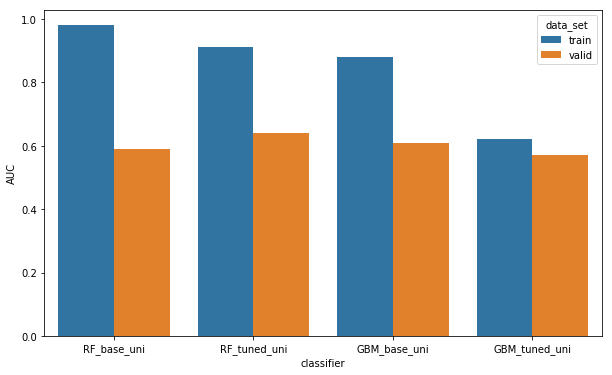

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x="classifier", hue="data_set", y="AUC", data=df_results)
plt.show()